# **Remote PPG (Photoplethysmography)**

In this notebook we will learn how to use Computer Vision to obtain an rPPG. 

## **(Brief) Background**
A [Photoplethysmography](https://www.news-medical.net/health/Photoplethysmography-(PPG).aspx) (PPG) is an optical technique that can detect volumetric changes in blood that correspond to the heart beat. PPGs are typically obtained by a contact optical sensor, but if sufficient lighting conditions are rpesent, we can use a Camera as our sensor and then use Computer Vision techniques to extract the PPG signal remotely.

![alt text](assets/rppg.webp "Title")

Refs:
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9346017
- https://www.mdpi.com/1999-4893/5/4/588
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8869811/
- https://www.news-medical.net/health/Photoplethysmography-(PPG).aspx
- https://arxiv.org/pdf/2202.04101.pdf

### Import Libraries

In [2]:
import os
import time
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt

%matplotlib inline

import sys
sys.path.append("../")

# local imports
from yunet import YuNet
from utils import *

### Config

In [58]:
MODEL_PATH = r"../models"

_FACE_MODEL = "face_detection_yunet_2023mar_int8.onnx"
_FACE_LANDM = "shape_predictor_68_face_landmarks_GTX.dat"

FACE_MODEL = os.path.join(MODEL_PATH, _FACE_MODEL)
FACE_LANDM = os.path.join(MODEL_PATH, _FACE_LANDM)


DEVICE_ID = 0
DEVICE_ID = "long_video.avi"

# face region to use for signal
FULL_SIGNAL = False
REGION_SIGNAL = True

COLOR = (0, 255, 0)

# override Frame Rate if necessary
FPS = None

### Get Models

In [59]:
face_model = YuNet(modelPath=FACE_MODEL,
                   inputSize=[320, 320],
                   confThreshold=0.5,
                   nmsThreshold=0.3,
                   topK=1, # set number of faces here
                   backendId=cv2.dnn.DNN_BACKEND_OPENCV,
                   targetId=cv2.dnn.DNN_TARGET_CPU)

# dlib ERT model
landmark_predictor = dlib.shape_predictor(FACE_LANDM)

### Stream Video to get frames

In [60]:
cap = cv2.VideoCapture(DEVICE_ID)

fs = cap.get(cv2.CAP_PROP_FPS)

# try to increase base frame rate
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
cap.set(cv2.CAP_PROP_FPS, 30)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))


# set input size
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# downsize frames if necessary
# w = w//4
# h = h//4

face_model.setInputSize((w, h))


# let camera warmup
time.sleep(2) 

# store values
cnt = 0
face_detections = None
red = 0
green = 0
blue = 0

frames = []

# store signals
red_signals = []
green_signals = []
blue_signals = []

if not cap.isOpened():
    print("Cannot open camera")
    exit()

fps = 0
tic = cv2.getTickCount() / cv2.getTickFrequency()
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame Exiting ...")
        break
    
    # resize frame
    frame = cv2.resize(frame, (w, h))
    
    # store frames
    frames.append(frame.copy())

    # get grayscale frame and 3 channel mask
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    display_frame = np.copy(frame)

    # compute frames per second
    if cnt % 5 == 0:
        toc = cv2.getTickCount() / cv2.getTickFrequency()
        fps = cnt / (toc - tic)
        # reset
        cnt = 0
        tic = cv2.getTickCount() / cv2.getTickFrequency()


    # ====================================================================
        
    # get face predictions
    face_detections = face_model.infer(frame)

    # process frame if any faces are detected
    if len(face_detections) > 0:
        
        # get Facial Landmarks for each face
        for pred in face_detections:
            face_box = pred[:4] # box in xywh format
            landmarks = get_facial_landmarks(landmark_predictor, 
                                             gray, face_box, extend=True)
            
            # draw landmarks on display frame
            for (x, y) in landmarks:
                cv2.circle(display_frame, (x, y), 2, (0, 0, 255), -1)

            # get signal mask
            mask = np.zeros_like(frame)

            # full signal
            if FULL_SIGNAL:
                poly = get_polygon(landmarks, FACE_OVAL)
                mask = cv2.fillConvexPoly(mask, poly, color=(255,255,255))
                
                for connections in [LEFT_EYE, RIGHT_EYE, MOUTH]:
                    poly = get_polygon(landmarks, connections)
                    mask = cv2.fillConvexPoly(mask, poly, color=(0,0,0))

                # draw on face
                connections_list = [FACE_OVAL, LEFT_EYE, RIGHT_EYE, MOUTH]
                display_frame = draw_lines(display_frame, landmarks, 
                                           connections_list, color=(0, 255, 0))


            # get only forehead and cheek regions
            elif REGION_SIGNAL:
                for connections in [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD]:
                    poly = get_polygon(landmarks, connections)
                    mask = cv2.fillConvexPoly(mask, poly, color=(255,255,255))

                # draw on face
                connections_list = [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD]
                display_frame = draw_lines(display_frame, landmarks, 
                                           connections_list, color=(0, 255, 0))

            # mask the frame
            frame &= mask

        # ====================================================================
        # extract signal from frame 
        blue = frame[:, :, 0]
        green = frame[:, :, 1]
        red = frame[:, :, 2]

        blue = blue.sum()/np.count_nonzero(blue)
        green = green.sum()/np.count_nonzero(green)
        red = red.sum()/np.count_nonzero(red)

    else:
        # place 0's or NaNs in signal lists
        red = 0
        green = 0
        blue = 0

    # append signals to list
    red_signals.append(red)
    green_signals.append(green)
    blue_signals.append(blue)

    # draw signal levels on frame
    cv2.putText(display_frame, "Red: {:.2f}".format(red), (50, 75),
            cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255), 3)
    cv2.putText(display_frame, "Green: {:.2f}".format(green), (50, 100),
            cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 3)
    cv2.putText(display_frame, "Blue: {:.2f}".format(blue), (50, 125),
            cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,128,0), 3)

    # draw fps on frame
    cv2.putText(display_frame, "FPS: {:.2f}".format(fps), (50, 25),
            cv2.FONT_HERSHEY_SIMPLEX, 0.75, COLOR, 4)

    # display frame
    cv2.imshow('frame', display_frame)

    # press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

    cnt += 1

# when finished, release the capture
cap.release()
cv2.destroyAllWindows()
del cap

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread (0x76028c0).
Cannot move to target thread (0x432ed20)

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread (0x76028c0).
Cannot move to target thread (0x432ed20)

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread (0x76028c0).
Cannot move to target thread (0x432ed20)

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread (0x76028c0).
Cannot move to target thread (0x432ed20)

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread (0x76028c0).
Cannot move to target thread (0x432ed20)

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread (0x76028c0).
Cannot move to target thread (0x432ed20)

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread (0x76028c0).
Cannot move to target thread (0x432ed20)

QObject::moveToThread: Current thread (0x432ed20) is not the object's thread

Can't receive frame Exiting ...


### Display Collected data

In [61]:
time_values = np.arange(0, len(frames))/fps

Text(0.5, 0, 'Time (Seconds)')

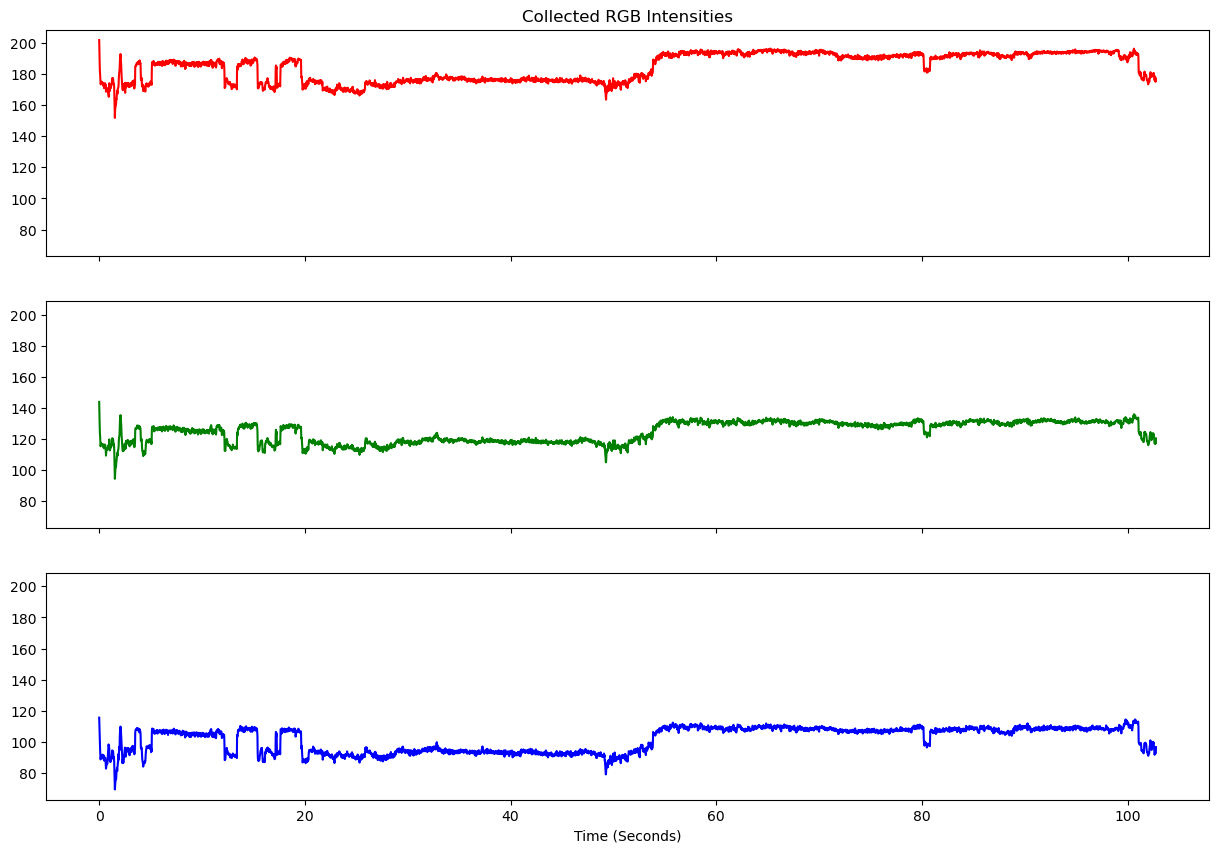

In [62]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)
ax[0].plot(time_values, red_signals, color='red')
ax[0].set_title("Collected RGB Intensities")
ax[1].plot(time_values, green_signals, color='green')
ax[2].plot(time_values, blue_signals, color='blue')
ax[2].set_xlabel("Time (Seconds)")

### Get Temporal Filter

In this section we will obtain an FIR bandpass filter and take it's DFT so that we can perform frequency domain filtering.

#### NOTE:
It's crucial that the sampleing rate *fs* is correct, if you are streaming in a saved video, it is likely that you are using a different sampling rate. 

In [123]:
# override with detected sample rate if necessary
fps = fs

In [124]:
import scipy.signal as signal

freq_lo = 0.75
freq_hi = 1.15 # 4.0
video_fs = 16.5 # fps

bandpass = signal.firwin(numtaps=len(frames),
                         cutoff=(freq_lo, freq_hi),
                         fs=fps, 
                         pass_zero=False)

transfer_function = np.fft.fft(np.fft.ifftshift(bandpass)).astype(np.complex64)

### Perform Freuqency Domain Fitlering

This isn't as hard as it sounds, we just need to take the DFT of each RGB signal and multiply it with our transfer function. Then we can take the inverse DFT to get the filtered signals

In [125]:
red_dft = np.fft.fft(red_signals)
green_dft = np.fft.fft(green_signals)
blue_dft = np.fft.fft(blue_signals)

In [126]:
filtered_red = np.fft.ifft(red_dft*transfer_function).real
filtered_green = np.fft.ifft(green_dft*transfer_function).real
filtered_blue = np.fft.ifft(blue_dft*transfer_function).real

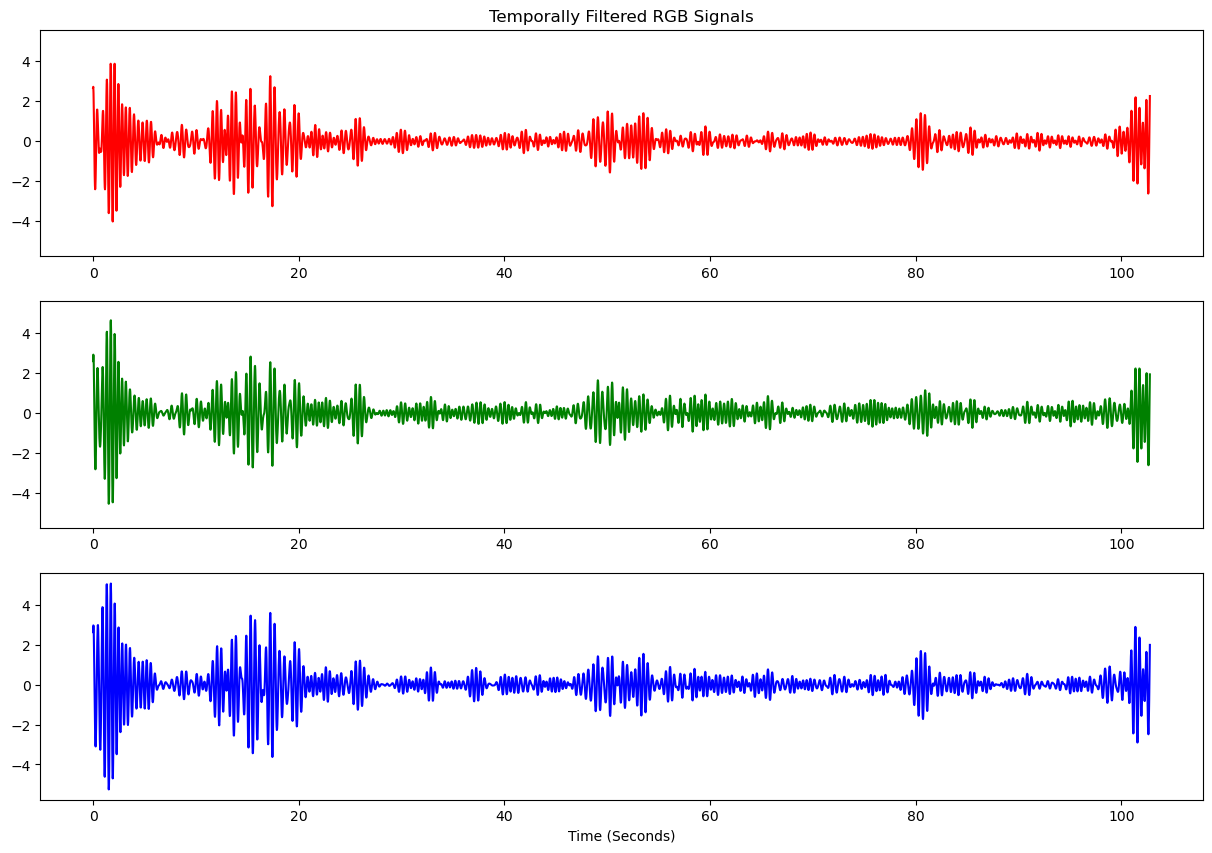

In [127]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharey=True)
ax[0].plot(time_values, filtered_red, color='red')
ax[0].set_title("Temporally Filtered RGB Signals")
ax[1].plot(time_values, filtered_green, color='green')
ax[2].plot(time_values, filtered_blue, color='blue')
ax[2].set_xlabel("Time (Seconds)");

### DFT of filtered signals

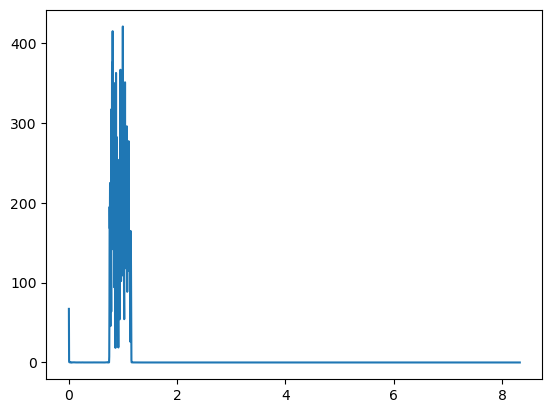

In [128]:
dft = np.fft.rfft(filtered_red)
freqs = np.fft.rfftfreq(len(frames)) * fps # fs

plt.plot(freqs, np.abs(dft))

### Convert RGB signals to a single BLood Volume Pulse Signal

In [129]:
rgb_signal = np.vstack((filtered_red, filtered_green, filtered_blue))
rgb_signal = rgb_signal[None, :, :]
rgb_signal.shape

(1, 3, 4515)

##### Either use OMIT or CHROM method

OMIT

In [130]:
bvp = []
for i in range(rgb_signal.shape[0]):
    X = rgb_signal[i]
    Q, R = np.linalg.qr(X)
    S = Q[:, 0].reshape(1, -1)
    P = np.identity(3) - np.matmul(S.T, S)
    Y = np.dot(P, X)
    bvp.append(Y[1, :])
bvp = np.array(bvp).squeeze(0)

CHROME

In [131]:
# X = rgb_signal
# Xcomp = 3*X[:, 0] - 2*X[:, 1]
# Ycomp = (1.5*X[:, 0])+X[:, 1]-(1.5*X[:, 2])
# sX = np.std(Xcomp, axis=1)
# sY = np.std(Ycomp, axis=1)
# alpha = (sX/sY).reshape(-1, 1)
# alpha = np.repeat(alpha, Xcomp.shape[1], 1)
# bvp = Xcomp - np.multiply(alpha, Ycomp)
# bvp = np.squeeze(bvp)

##### Display BVP signal

In [132]:
bvp_dft = np.fft.rfft(bvp)/len(frames)

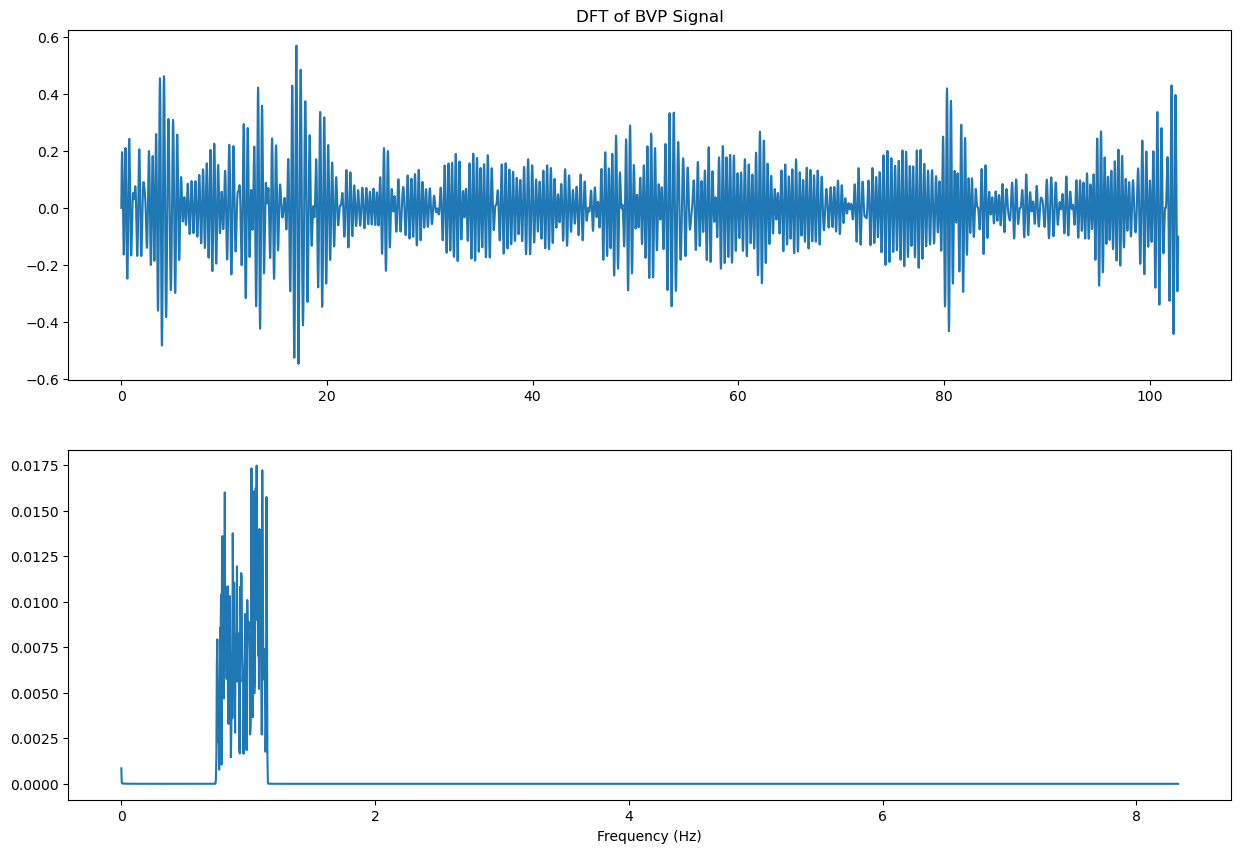

In [133]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(time_values, bvp)
ax[0].set_title("Blood Volume Pulse (BPV) Signal")
ax[1].set_xlabel("Time (Seconds)");
ax[0].set_title("DFT of BVP Signal")
ax[1].plot(freqs, np.abs(bvp_dft))
ax[1].set_xlabel("Frequency (Hz)");

### Get Spectrogram

In [134]:
f, t, Sxx = signal.spectrogram(bvp, nperseg=256, fs=fps, detrend='constant')

Display in terms of Frequency

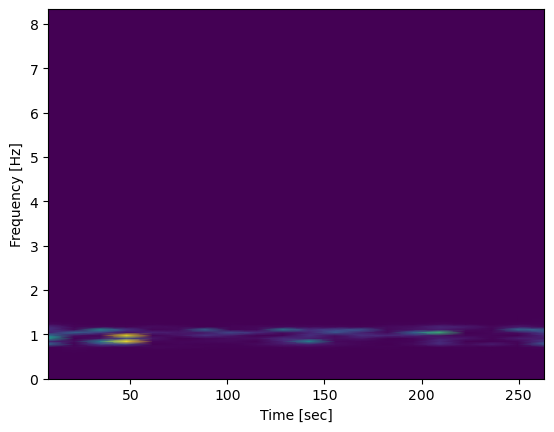

In [135]:
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]');

Display in terms of Beats per Minute

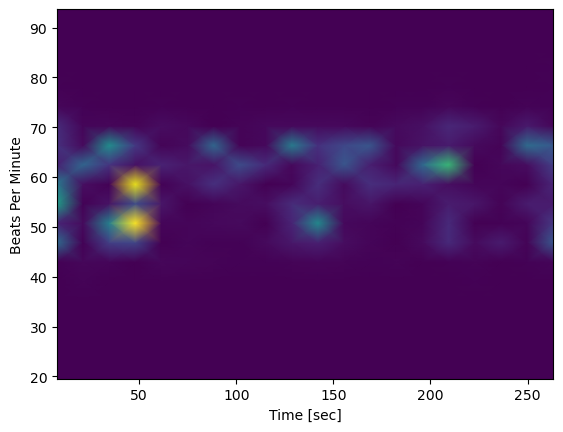

In [136]:
plt.pcolormesh(t, f[5:25]*60, Sxx[5:25, :], shading='gouraud')
# plt.pcolormesh(t, f*60, Sxx, shading='gouraud')
plt.ylabel('Beats Per Minute')
plt.xlabel('Time [sec]');

In [137]:
Sxx.shape

(129, 20)

### Display Beats per Minute VS Time

(This assumes that the peak value contains the hear rate)

In [138]:
bpm = f[Sxx.argmax(axis=0)]*60

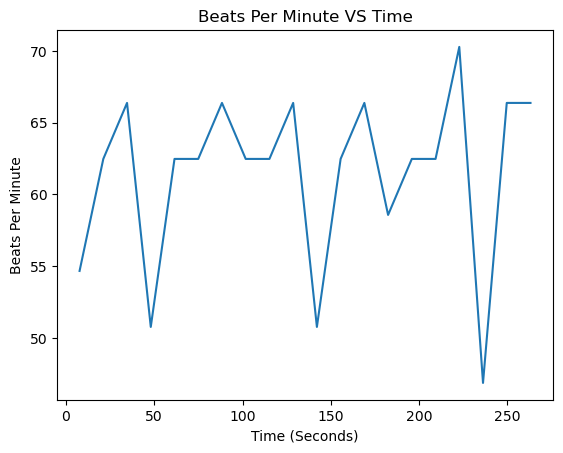

In [139]:
plt.plot(t, bpm);
plt.title("Beats Per Minute VS Time")
plt.xlabel("Time (Seconds)")
plt.ylabel("Beats Per Minute");